In [1]:
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
print(torch.cuda.is_available())
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
print(torch.cuda.get_device_properties(0).total_memory)
print(torch.cuda.memory_allocated())
gpu_id = 2

True
11721506816
0


In [2]:
!nvidia-smi

Mon Jul 19 20:21:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   26C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   24C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [6]:
my_path = '../../dataset/sharma_59_nih_dataset/Image_dataset/'
path_0 = my_path+'0_0/'
path_1 = my_path + '1_1/'
print(len(os.listdir(path_0)))
print(len(os.listdir(path_1)))


# torchvision.transforms.Normalize(mean=torch.rand(3),std = torch.rand(3))
transformations = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
#                                                   torchvision.transforms.CenterCrop(224),
                                                  torchvision.transforms.ToTensor()])

images = torchvision.datasets.ImageFolder(root=my_path,transform=transformations)
train_data,validate_data,test_data = torch.utils.data.dataset.random_split(images,[8020,2286,1146])
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(dataset = validate_data,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=64,shuffle=True)


print(images.class_to_idx)

5727
5725
{'0_0': 0, '1_1': 1}


In [7]:
image,label = next(iter(train_loader))
print(image.shape)



torch.Size([64, 3, 224, 224])


tensor(1.)


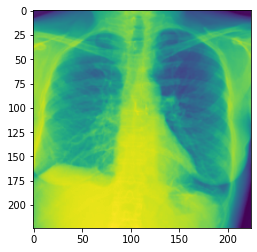

In [8]:
print(torch.max(image))
plt.imshow(image[0][0])

In [6]:
def check_acc(loader,model,name,fpr={},tpr={},auc_={}):
    model.eval()
    correct = 0;samples=0

    pre = []
    lab = []
    predicted_labels = []
    
    with torch.no_grad():
        for idx,(x, y) in enumerate(loader):
            
            x = Normalize_data(x)
            x = x.cuda(gpu_id)
            y = y.cuda(gpu_id)
            
            scores=model(x)
            predict_prob = F.softmax(scores)
            _,predictions=predict_prob.max(1)
            
            predictions = predictions.to('cpu')
            y = y.to('cpu')
            predict_prob = predict_prob.to('cpu')
            
            predicted_labels.extend(list(predictions.numpy()))
            pre.extend(list(predict_prob.numpy()))
            lab.extend(list(y.numpy()))
            
            correct += (predictions==y).sum()
            samples += predictions.size(0)
            
            torch.cuda.empty_cache()
        
        print(f'correct are {correct}/{samples}')
        
        lab = np.array(lab)
        pre = np.array(pre)
        
    fpr[name],tpr[name],_= roc_curve(lab,pre[:,1])
    auc_[name] = auc(fpr[name],tpr[name])
    model.train()
    return lab,pre,predicted_labels,correct/samples

def check_acc_batch(batch,labels,model):
    model.eval()
    correct = 0
    samples=0
    with torch.no_grad():
        
        scores=model(batch)
        scores = F.softmax(scores)
        _,predicted = torch.max(scores,axis=1)
        correct += (predicted==labels).sum()
        samples += scores.shape[0]
#         print(f"correct : [{correct}/{samples}]")
        torch.cuda.empty_cache()

    model.train()
    return correct/samples




def Normalize_data(data):
#     data = data/255
    for i in range(data.shape[0]):
        mean = torch.mean(data[i],dim = [1,2])
        std = torch.std(data[i],dim=[1,2])
        transform = transforms.Compose([transforms.Normalize(mean,std)])
        data[i] = transform(data[i])
    return data

def Normalize_data_train(data):
#     data = data/255
    for i in range(data.shape[0]):
        mean = torch.mean(data[i],dim = [1,2])
        std = torch.std(data[i],dim=[1,2])
        transform = transforms.Compose([transforms.RandomHorizontalFlip(p = 0.6),
#                                         transforms.RandomRotation(10),
                                        transforms.Normalize(mean,std)])
        data[i] = transform(data[i])
    return data




def count_parameters(model):
    table = PrettyTable(["layer", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    


In [7]:
def train_model(model1,Losses_,optimizer,schedular,lr,n_epochs,overall_loss=[],overall_acc=[],val_loss=[],val_accuracy=[]):
    weight_decay = 0.0001
    
    best_validation_acc = 0.5
    best_model = model1.state_dict()
    best_optimizer = optimizer.state_dict()
    
    for epochs in range(n_epochs):
        batch_loss = []
        batch_acc = [] 
        val_batch_loss= []
        val_batch_acc = []
        for idx , (data,target) in enumerate(train_loader):


            """ mean normalization """
            data = Normalize_data_train(data)
            
            data = data.cuda(gpu_id)
            target = target.cuda(gpu_id)
            
            scores = model1(data)
            
#             l1_reg_loss = 0
#             for params in model1.parameters():
#                 l1_reg_loss += torch.sum(abs(params))

            l2_reg_loss =0 
            for params in model1.parameters():
                l2_reg_loss += torch.norm(params)
                
            loss = Losses_(scores,target)+ weight_decay*l2_reg_loss
            batch_loss.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_accuracy = check_acc_batch(data,target,model1)
            batch_acc.append(float(batch_accuracy))
            
        model1.eval()

        for idx ,(data,target) in enumerate(validate_loader):

            data = Normalize_data(data)

            data = data.cuda(gpu_id)
            target = target.cuda(gpu_id)

            scores = model1(data)
            loss = Losses_(scores,target)
            val_batch_loss.append(float(loss))

            batch_accuracy = check_acc_batch(data,target,model1)
            val_batch_acc.append(float(batch_accuracy))

        model1.train()

        occupied_memory = torch.cuda.memory_allocated(gpu_id)/(1024*1024*1024)
        total_memory = torch.cuda.get_device_properties(gpu_id).total_memory/(1024*1024*1024)

        overall_loss.append(batch_loss)
        overall_acc.append(batch_acc)
        val_loss.append(val_batch_loss)
        val_accuracy.append(val_batch_acc)

        valid_acc = np.mean(val_batch_acc)
        if(valid_acc > best_validation_acc):
            print("one of the best validation acc found")
            best_validation_acc = valid_acc
            best_model = model1.state_dict()
            best_optimizer = optimizer.state_dict()
        
        schedular.step()

        print(f'epoch:[{epochs+1}/{n_epochs}],memory:[{occupied_memory}/{total_memory}]') 
        print(f'train_accuracy:{np.mean(batch_acc)}, train_loss:{np.mean(batch_loss)},val_acc:{np.mean(val_batch_acc)},val_loss:{np.mean(val_batch_loss)} ,learning_rate:{optimizer.param_groups[0]["lr"]}')
            
    return best_model,best_optimizer

      
      

In [8]:
shuffle_v2 = torchvision.models.shufflenet_v2_x1_0(pretrained=True)

print(shuffle_v2)

count_parameters(shuffle_v2)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [9]:
# for params in shuffle_v2.parameters():
#     params.requires_grad=False
    
shuffle_v2.fc = nn.Sequential(nn.Linear(in_features=1024,out_features=64),
                             nn.ReLU(),
                             nn.Linear(64,2))
shuffle_v2 = shuffle_v2.cuda(gpu_id)
print(shuffle_v2)
count_parameters(shuffle_v2)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [10]:
torch.cuda.memory_allocated(gpu_id)/(1024*1024*1024)

0.005048274993896484

In [11]:
!nvidia-smi

Thu Jul 15 19:18:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   28C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   27C    P8     7W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [12]:

Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=shuffle_v2.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=8,gamma=0.1)
overall_loss=[]
overall_acc=[]
val_loss=[]
val_accuracy=[]
n_epochs=50
best_model,best_optimizer = train_model(shuffle_v2,Losses_,optimizer,schedular,lr,n_epochs,overall_loss,overall_acc,val_loss,val_accuracy)


epoch:[1/50],memory:[0.8513545989990234/10.91650390625]
train_accuracy:0.6347470240933555, train_loss:7.12920063639444,val_acc:0.6644776579406526,val_loss:0.6202283087703917 ,learning_rate:0.0003
epoch:[2/50],memory:[0.8513545989990234/10.91650390625]
train_accuracy:0.7032738096184201, train_loss:5.111423038301014,val_acc:0.678064614534378,val_loss:0.6106638453072972 ,learning_rate:0.0003
epoch:[3/50],memory:[0.8513545989990234/10.91650390625]
train_accuracy:0.7172867064438169, train_loss:4.270157221763853,val_acc:0.6714032308922874,val_loss:0.6190791444645988 ,learning_rate:0.0003
epoch:[4/50],memory:[0.8513545989990234/10.91650390625]
train_accuracy:0.7428075396825397, train_loss:3.8646969151875328,val_acc:0.6639304045173857,val_loss:0.6296179418762525 ,learning_rate:0.0003
epoch:[5/50],memory:[0.8513545989990234/10.91650390625]
train_accuracy:0.7711557542520856, train_loss:3.634874972086104,val_acc:0.6623075190517638,val_loss:0.6345268819067214 ,learning_rate:0.0003
epoch:[6/50],mem

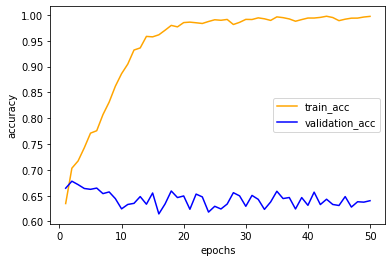

In [13]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_acc,axis=1),color='orange',label='train_acc')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_accuracy,axis=1),color='blue',label='validation_acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

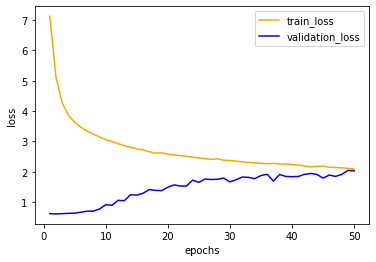

In [14]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_loss,axis=1),color='orange',label='train_loss')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_loss,axis=1),color='blue',label='validation_loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [15]:
fpr = {}
tpr = {}
auc_ = {}
labels_test,prob_test,predicted_test,acc_test = check_acc(test_loader,shuffle_v2,'test',fpr,tpr,auc_)
print(acc_test)
labels_train,prob_train,predicted_train,acc_train = check_acc(train_loader,shuffle_v2,'train',fpr,tpr,auc_)
print(acc_train)
labels_valid,prob_valid,predicted_valid,acc_valid = check_acc(validate_loader,shuffle_v2,'val',fpr,tpr,auc_)
print(acc_valid)

correct are 735/1146
tensor(0.6414)
correct are 7868/8020
tensor(0.9810)
correct are 1451/2286
tensor(0.6347)


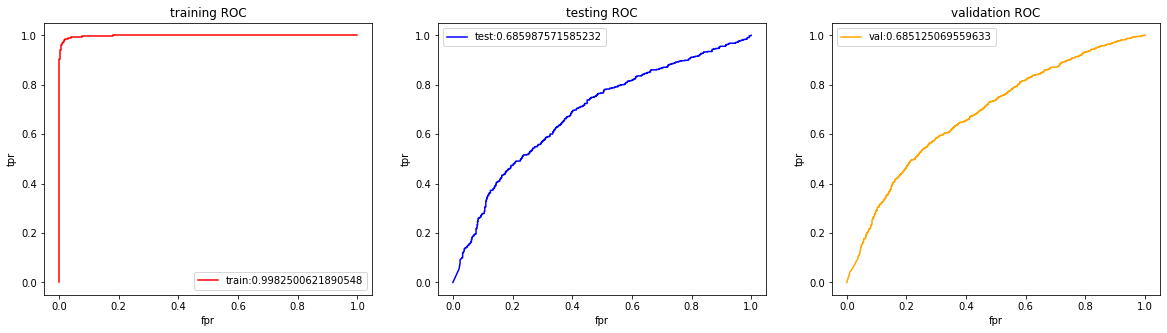

In [16]:
figure , axis = plt.subplots(1,3,figsize=(20,5))

axis[0].plot(fpr['train'],tpr['train'],label=f"train:{auc_['train']}",color='red')
axis[0].set_xlabel('fpr')
axis[0].set_ylabel('tpr')
axis[0].legend()
axis[0].set_title('training ROC')

axis[1].plot(fpr['test'],tpr['test'],label=f"test:{auc_['test']}",color='blue')
axis[1].set_xlabel('fpr')
axis[1].set_ylabel('tpr')
axis[1].legend()
axis[1].set_title('testing ROC')

axis[2].plot(fpr['val'],tpr['val'],label=f"val:{auc_['val']}",color='orange')
axis[2].set_xlabel('fpr')
axis[2].set_ylabel('tpr')
axis[2].legend()
axis[2].set_title('validation ROC')

plt.show()


[[380 200]
 [211 355]]
precision :  0.6396396396396397
recall :  0.627208480565371


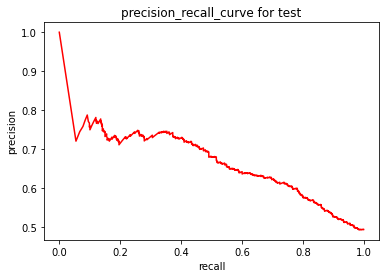

In [17]:
print(confusion_matrix(labels_test,predicted_test))
print("precision : ",precision_score(labels_test,predicted_test))
print("recall : ",recall_score(labels_test,predicted_test))
precision_test,recall_test,_= precision_recall_curve(labels_test,prob_test[:,1])
plt.plot(recall_test,precision_test,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for test")
plt.show()

[[3917   83]
 [  69 3951]]
precision :  0.9794248884481904
recall :  0.9828358208955223


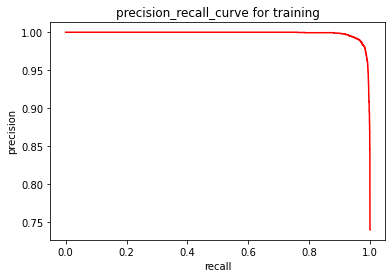

In [18]:
print(confusion_matrix(labels_train,predicted_train))
print("precision : ",precision_score(labels_train,predicted_train))
print("recall : ",recall_score(labels_train,predicted_train))
precision_train,recall_train,_= precision_recall_curve(labels_train,prob_train[:,1])
plt.plot(recall_train,precision_train,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for training")
plt.show()

In [19]:
os.listdir(os.getcwd())

['check.ipynb',
 'models_for_lungs_disease_classification.ipynb',
 '.ipynb_checkpoints',
 'saved_models',
 'squeezenet_lungs_image_classification.ipynb',
 'parallel_model_for_lungs_classification.ipynb']

In [22]:
my_dir = 'saved_models/shuffle_net_1_0_cuda2.pth'
try:
    torch.save({'best_model':best_model,'best_opt':best_optimizer},my_dir)
    print("model saved")
except Exception as e:
    print(e)
    

model saved


In [23]:
best_model

OrderedDict([('conv1.0.weight',
              tensor([[[[ 6.6968e-01,  1.8237e-01, -2.0749e-01],
                        [ 9.8282e-03, -1.4181e+00, -3.4278e-02],
                        [-2.9228e-01,  1.8605e-01,  8.4141e-01]],
              
                       [[ 1.3655e+00,  2.0086e-01, -4.5771e-01],
                        [-6.9493e-02, -2.1459e+00, -2.3201e-01],
                        [-4.6414e-01,  9.7404e-02,  1.4209e+00]],
              
                       [[ 3.6690e-01,  2.0660e-01, -1.5093e-01],
                        [ 1.1865e-01, -8.1127e-01,  2.7296e-03],
                        [-1.8347e-01,  1.1002e-01,  3.2664e-01]]],
              
              
                      [[[ 6.6759e-01,  9.4085e-01,  7.2920e-01],
                        [ 1.3038e-01,  1.6806e-01,  1.1283e-01],
                        [-7.9090e-01, -1.1374e+00, -8.7706e-01]],
              
                       [[ 1.1257e+00,  1.5330e+00,  1.1938e+00],
                        [ 1.5333e-01,  1.46

In [24]:
shuffle = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
shuffle.fc = nn.Linear(in_features=1024,out_features=2)


In [25]:
shuffle.state_dict()

OrderedDict([('conv1.0.weight',
              tensor([[[[ 6.6333e-01,  1.8131e-01, -2.2612e-01],
                        [ 9.4423e-03, -1.4384e+00, -5.1944e-02],
                        [-3.1551e-01,  1.8218e-01,  8.4179e-01]],
              
                       [[ 1.3592e+00,  1.9981e-01, -4.7635e-01],
                        [-8.9195e-02, -2.1661e+00, -2.4968e-01],
                        [-4.8738e-01,  9.3537e-02,  1.4212e+00]],
              
                       [[ 3.6055e-01,  2.0555e-01, -1.6957e-01],
                        [ 1.1826e-01, -8.3150e-01,  2.1155e-03],
                        [-2.0670e-01,  1.0616e-01,  3.2702e-01]]],
              
              
                      [[[ 6.6285e-01,  9.4100e-01,  7.3111e-01],
                        [ 1.2443e-01,  1.6640e-01,  1.1477e-01],
                        [-8.0724e-01, -1.1485e+00, -8.8345e-01]],
              
                       [[ 1.1209e+00,  1.5331e+00,  1.1957e+00],
                        [ 1.4738e-01,  1.44

In [27]:
shuffle = shuffle.cuda(gpu_id)
labels_test,prob_test,predicted_test,acc_test = check_acc(test_loader,shuffle,'test',fpr,tpr,auc_)
print(acc_test)

correct are 582/1146
tensor(0.5079)


In [28]:
my_model = torch.load(my_dir,map_location='cuda:2')
shuffle.load_state_dict(my_model['best_model'])

<All keys matched successfully>

In [29]:
shuffle.state_dict()

OrderedDict([('conv1.0.weight',
              tensor([[[[ 6.6968e-01,  1.8237e-01, -2.0749e-01],
                        [ 9.8282e-03, -1.4181e+00, -3.4278e-02],
                        [-2.9228e-01,  1.8605e-01,  8.4141e-01]],
              
                       [[ 1.3655e+00,  2.0086e-01, -4.5771e-01],
                        [-6.9493e-02, -2.1459e+00, -2.3201e-01],
                        [-4.6414e-01,  9.7404e-02,  1.4209e+00]],
              
                       [[ 3.6690e-01,  2.0660e-01, -1.5093e-01],
                        [ 1.1865e-01, -8.1127e-01,  2.7296e-03],
                        [-1.8347e-01,  1.1002e-01,  3.2664e-01]]],
              
              
                      [[[ 6.6759e-01,  9.4085e-01,  7.2920e-01],
                        [ 1.3038e-01,  1.6806e-01,  1.1283e-01],
                        [-7.9090e-01, -1.1374e+00, -8.7706e-01]],
              
                       [[ 1.1257e+00,  1.5330e+00,  1.1938e+00],
                        [ 1.5333e-01,  1.46

In [30]:
labels_test,prob_test,predicted_test,acc_test = check_acc(test_loader,shuffle,'test',fpr,tpr,auc_)
print(acc_test)

correct are 735/1146
tensor(0.6414)


In [10]:

Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=shuffle_v2.parameters(),lr=lr,weight_decay = 1e-4)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
overall_loss=[]
overall_acc=[]
val_loss=[]
val_accuracy=[]
n_epochs=50
best_model,best_optimizer = train_model(shuffle_v2,Losses_,optimizer,schedular,lr,n_epochs,overall_loss,overall_acc,val_loss,val_accuracy)


epoch:[1/50],memory:[0.8505773544311523/10.91650390625]
train_accuracy:0.6526537698412699, train_loss:0.7583304676744673,val_acc:0.6922365642256207,val_loss:0.5950420233938429 ,learning_rate:0.0003
epoch:[2/50],memory:[0.8505773544311523/10.91650390625]
train_accuracy:0.6998759919688815, train_loss:0.7089779164109912,val_acc:0.6887832134962082,val_loss:0.5982982019583384 ,learning_rate:0.0003
epoch:[3/50],memory:[0.8505773544311523/10.91650390625]
train_accuracy:0.7245287701251015, train_loss:0.6737479383037204,val_acc:0.6812160329686271,val_loss:0.6179661576946577 ,learning_rate:0.0003
epoch:[4/50],memory:[0.8505773544311523/10.91650390625]
train_accuracy:0.7608382938400148, train_loss:0.6333840349836956,val_acc:0.6688934183783002,val_loss:0.6385649061865277 ,learning_rate:0.0003
epoch:[5/50],memory:[0.8505773544311523/10.91650390625]
train_accuracy:0.8079613097130306, train_loss:0.57418173906349,val_acc:0.6782533211840523,val_loss:0.6806813461913003 ,learning_rate:0.0003
epoch:[6/50]

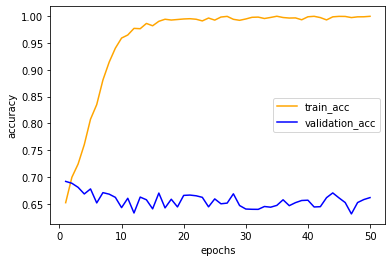

In [11]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_acc,axis=1),color='orange',label='train_acc')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_accuracy,axis=1),color='blue',label='validation_acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

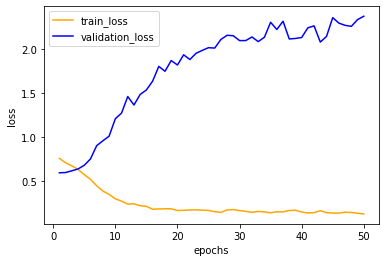

In [12]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_loss,axis=1),color='orange',label='train_loss')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_loss,axis=1),color='blue',label='validation_loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [13]:
fpr = {}
tpr = {}
auc_ = {}
labels_test,prob_test,predicted_test,acc_test = check_acc(test_loader,shuffle_v2,'test',fpr,tpr,auc_)
print(acc_test)
labels_train,prob_train,predicted_train,acc_train = check_acc(train_loader,shuffle_v2,'train',fpr,tpr,auc_)
print(acc_train)
labels_valid,prob_valid,predicted_valid,acc_valid = check_acc(validate_loader,shuffle_v2,'val',fpr,tpr,auc_)
print(acc_valid)

correct are 739/1146
tensor(0.6449)
correct are 7981/8020
tensor(0.9951)
correct are 1505/2286
tensor(0.6584)


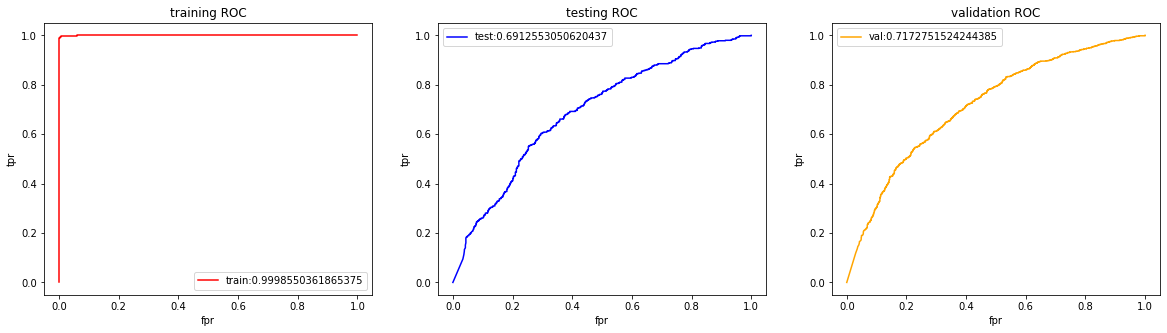

In [14]:
figure , axis = plt.subplots(1,3,figsize=(20,5))

axis[0].plot(fpr['train'],tpr['train'],label=f"train:{auc_['train']}",color='red')
axis[0].set_xlabel('fpr')
axis[0].set_ylabel('tpr')
axis[0].legend()
axis[0].set_title('training ROC')

axis[1].plot(fpr['test'],tpr['test'],label=f"test:{auc_['test']}",color='blue')
axis[1].set_xlabel('fpr')
axis[1].set_ylabel('tpr')
axis[1].legend()
axis[1].set_title('testing ROC')

axis[2].plot(fpr['val'],tpr['val'],label=f"val:{auc_['val']}",color='orange')
axis[2].set_xlabel('fpr')
axis[2].set_ylabel('tpr')
axis[2].legend()
axis[2].set_title('validation ROC')

plt.show()


[[375 222]
 [185 364]]
precision :  0.621160409556314
recall :  0.663023679417122


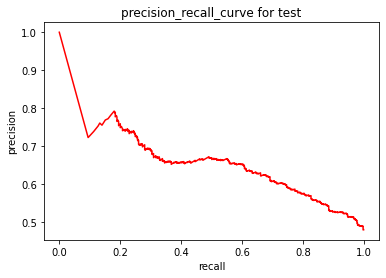

In [15]:
print(confusion_matrix(labels_test,predicted_test))
print("precision : ",precision_score(labels_test,predicted_test))
print("recall : ",recall_score(labels_test,predicted_test))
precision_test,recall_test,_= precision_recall_curve(labels_test,prob_test[:,1])
plt.plot(recall_test,precision_test,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for test")
plt.show()

[[3978   17]
 [  22 4003]]
precision :  0.9957711442786069
recall :  0.9945341614906832


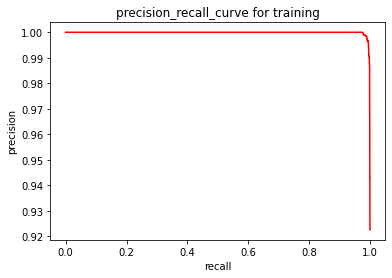

In [16]:
print(confusion_matrix(labels_train,predicted_train))
print("precision : ",precision_score(labels_train,predicted_train))
print("recall : ",recall_score(labels_train,predicted_train))
precision_train,recall_train,_= precision_recall_curve(labels_train,prob_train[:,1])
plt.plot(recall_train,precision_train,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for training")
plt.show()

In [19]:
# my_dir = 'saved_models/shuffle_net_1_0_cuda2_l2_reg.pth'
# try:
#     torch.save({'best_model':best_model,'best_opt':best_optimizer},my_dir)
#     print("model saved")
# except Exception as e:
#     print(e)
    

model saved


In [12]:

Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=shuffle_v2.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
overall_loss=[]
overall_acc=[]
val_loss=[]
val_accuracy=[]
n_epochs=60
best_model,best_optimizer = train_model(shuffle_v2,Losses_,optimizer,schedular,lr,n_epochs,overall_loss,overall_acc,val_loss,val_accuracy)


one of the best validation acc found
epoch:[1/60],memory:[1.0986580848693848/10.91650390625]
train_accuracy:0.6553571427625323, train_loss:0.7615019669608464,val_acc:0.6839145537879732,val_loss:0.601934434639083 ,learning_rate:0.0003
epoch:[2/60],memory:[1.0986580848693848/10.91650390625]
train_accuracy:0.691344246031746, train_loss:0.7122918055171058,val_acc:0.6833861718575159,val_loss:0.5934072410066923 ,learning_rate:0.0003
one of the best validation acc found
epoch:[3/60],memory:[1.0986580848693848/10.91650390625]
train_accuracy:0.7240327383790698, train_loss:0.6810471864919814,val_acc:0.6978789253367318,val_loss:0.5962713559468588 ,learning_rate:0.0003
epoch:[4/60],memory:[1.0986580848693848/10.91650390625]
train_accuracy:0.7610863097130306, train_loss:0.6426463060908847,val_acc:0.6813858697811762,val_loss:0.6170023754239082 ,learning_rate:0.0003
epoch:[5/60],memory:[1.0986580848693848/10.91650390625]
train_accuracy:0.8125744050457364, train_loss:0.5839795529369324,val_acc:0.64545

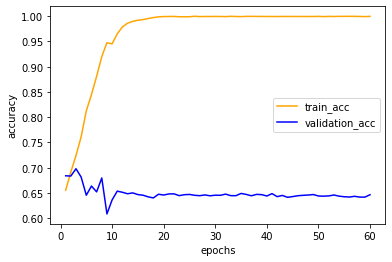

In [13]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_acc,axis=1),color='orange',label='train_acc')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_accuracy,axis=1),color='blue',label='validation_acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

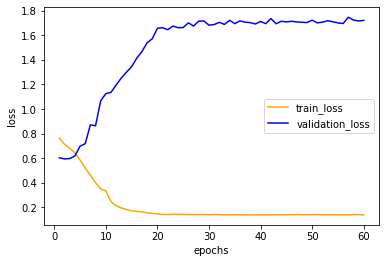

In [14]:
plt.plot(list(range(1,n_epochs+1)),np.mean(overall_loss,axis=1),color='orange',label='train_loss')
plt.plot(list(range(1,n_epochs+1)),np.mean(val_loss,axis=1),color='blue',label='validation_loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [15]:
fpr = {}
tpr = {}
auc_ = {}
labels_test,prob_test,predicted_test,acc_test = check_acc(test_loader,shuffle_v2,'test',fpr,tpr,auc_)
print(acc_test)
labels_train,prob_train,predicted_train,acc_train = check_acc(train_loader,shuffle_v2,'train',fpr,tpr,auc_)
print(acc_train)
labels_valid,prob_valid,predicted_valid,acc_valid = check_acc(validate_loader,shuffle_v2,'val',fpr,tpr,auc_)
print(acc_valid)

correct are 773/1146
tensor(0.6745)
correct are 8009/8020
tensor(0.9986)
correct are 1479/2286
tensor(0.6470)


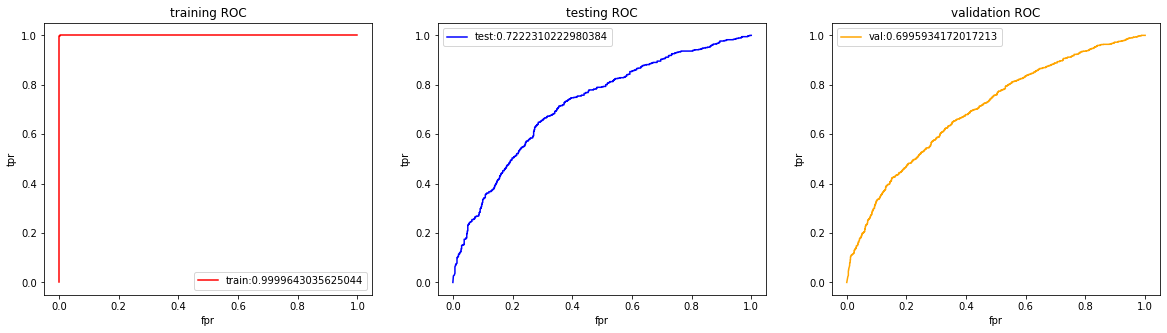

In [16]:
figure , axis = plt.subplots(1,3,figsize=(20,5))

axis[0].plot(fpr['train'],tpr['train'],label=f"train:{auc_['train']}",color='red')
axis[0].set_xlabel('fpr')
axis[0].set_ylabel('tpr')
axis[0].legend()
axis[0].set_title('training ROC')

axis[1].plot(fpr['test'],tpr['test'],label=f"test:{auc_['test']}",color='blue')
axis[1].set_xlabel('fpr')
axis[1].set_ylabel('tpr')
axis[1].legend()
axis[1].set_title('testing ROC')

axis[2].plot(fpr['val'],tpr['val'],label=f"val:{auc_['val']}",color='orange')
axis[2].set_xlabel('fpr')
axis[2].set_ylabel('tpr')
axis[2].legend()
axis[2].set_title('validation ROC')

plt.show()


[[381 199]
 [174 392]]
precision :  0.6632825719120136
recall :  0.6925795053003534


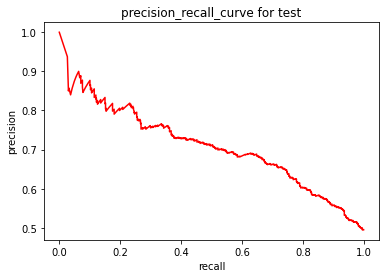

In [17]:
print(confusion_matrix(labels_test,predicted_test))
print("precision : ",precision_score(labels_test,predicted_test))
print("recall : ",recall_score(labels_test,predicted_test))
precision_test,recall_test,_= precision_recall_curve(labels_test,prob_test[:,1])
plt.plot(recall_test,precision_test,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for test")
plt.show()

[[4014    4]
 [   7 3995]]
precision :  0.9989997499374844
recall :  0.9982508745627187


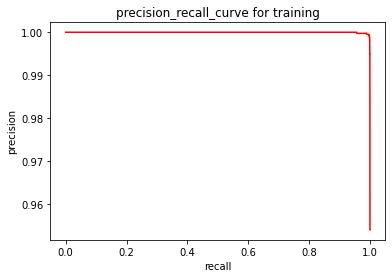

In [19]:
print(confusion_matrix(labels_train,predicted_train))
print("precision : ",precision_score(labels_train,predicted_train))
print("recall : ",recall_score(labels_train,predicted_train))
precision_train,recall_train,_= precision_recall_curve(labels_train,prob_train[:,1])
plt.plot(recall_train,precision_train,color='red')
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("precision_recall_curve for training")
plt.show()

In [23]:
my_dir = 'saved_models/shuffle_net_1_0_cuda2_l2_reg_68test.pth'
try:
    torch.save({'best_model':best_model,'best_opt':best_optimizer},my_dir)
    print("model saved")
except Exception as e:
    print(e)
    

model saved
